In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
print(df.shape)
print(df.describe())

(77338, 31)
               Time            V1  ...        Amount         Class
count  77338.000000  77338.000000  ...  77337.000000  77337.000000
mean   36633.048243     -0.254918  ...     97.617764      0.002431
std    14986.790777      1.883504  ...    270.498883      0.049245
min        0.000000    -56.407510  ...      0.000000      0.000000
25%    30195.250000     -1.016589  ...      7.680000      0.000000
50%    39488.000000     -0.248318  ...     26.750000      0.000000
75%    48186.000000      1.153837  ...     89.000000      0.000000
max    57006.000000      1.960497  ...  19656.530000      1.000000

[8 rows x 31 columns]


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
# Determine number of fraud cases in dataset 
fraud = df[df['Class'] == 1] 
valid = df[df['Class'] == 0] 
outlierFraction = len(fraud)/float(len(valid)) 
print(outlierFraction) 
print('Fraud Cases: {}'.format(len(df[df['Class'] == 1]))) 
print('Valid Transactions: {}'.format(len(df[df['Class'] == 0]))) 

0.002436842992132108
Fraud Cases: 188
Valid Transactions: 77149


Only 0.17% fraudulent transaction out all the transactions. The data is highly Unbalanced. Lets first apply our models without balancing it and if we don’t get a good accuracy then we can find a way to balance this dataset. But first, let’s implement the model without it and will balance the data only if needed.

In [21]:
# check for nan's

df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

In [23]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [24]:
# Establish our baseline

df['Class'].value_counts(normalize=True).max()

0.997569112208746

In [25]:
fraud.Amount.describe()

count     188.000000
mean       94.292500
std       214.093799
min         0.000000
25%         1.000000
50%         7.550000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [26]:
valid.Amount.describe()

count    77149.000000
mean        97.625867
std        270.623024
min          0.000000
25%          7.690000
50%         26.800000
75%         89.000000
max      19656.530000
Name: Amount, dtype: float64

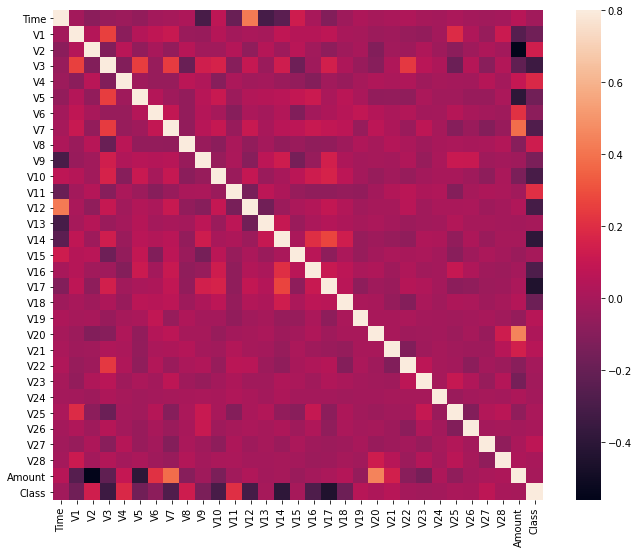

In [27]:
# Correlation Heat Map

corrmat = df.corr() 
fig = plt.figure(figsize = (12, 9)) 
sns.heatmap(corrmat, vmax = .8, square = True) 
plt.show()

In the Heat Map we can clearly see that most of the features do not correlate to other features, however there are some features that either positively or a negatively correlate with each other. Eg, V2 and V5 are highly negatively correlated with Amount. We also see some correlation with V20 and Amount. This gives us a deeper understanding of the Data available to us.

In [28]:
# dividing X and Y Values

X = df.drop(['Class'], axis=1)
Y = df['Class']
print(X.shape)
print(Y.shape)

# using only the values for processing

xData = X.values 
yData = Y.values

(77338, 30)
(77338,)


In [29]:
# Split data: train, validate, test

from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(xData, yData, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [30]:
# build the RFC

from sklearn.ensemble import RandomForestClassifier 

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

# prediction on validation set

y_pred = rfc.predict(x_val)

In [32]:
# evaluation metrics

from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 
  
n_outliers = len(fraud) 
n_errors = (y_pred != y_val).sum() 
print("The model used is Random Forest classifier") 
  
acc = accuracy_score(y_val, y_pred) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_val, y_pred) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_val, y_pred) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_val, y_pred) 
print("The F1-Score is {}".format(f1)) 
  
MCC = matthews_corrcoef(y_val, y_pred) 
print("The Matthews correlation coefficient is {}".format(MCC)) 

The model used is Random Forest classifier
The accuracy is 0.9996552021377467
The precision is 1.0
The recall is 0.7777777777777778
The F1-Score is 0.8750000000000001
The Matthews correlation coefficient is 0.881764865278002


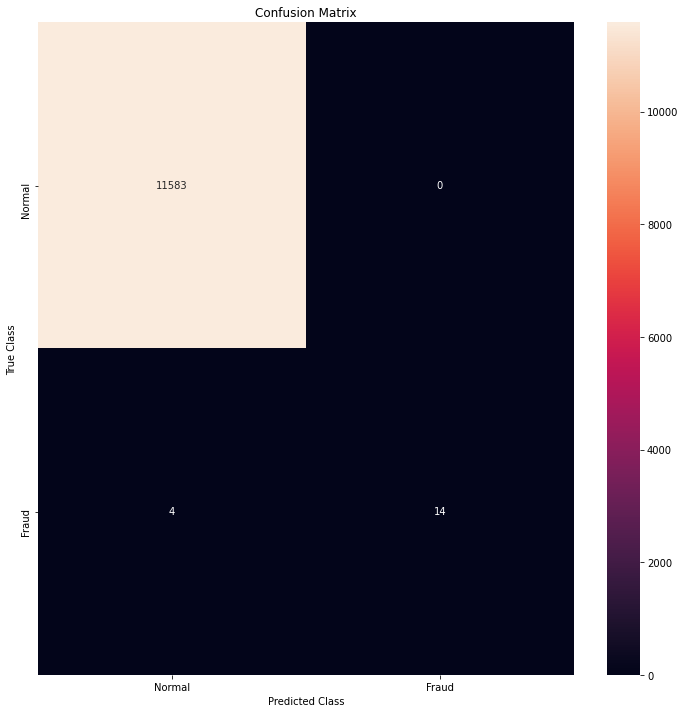

In [33]:
# Confusion Matrix

LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d');
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()